In [1]:
from sense_hat import SenseHat
import matplotlib.pyplot as plt
import numpy as np
import time, json

In [2]:
sense = SenseHat()
sense.set_rotation(180)
sense.show_message("PPT 2022")

In [3]:
def record_pendulum(mode='gyro',max_seconds=10):
    data = {'time':[],'roll':[],'pitch':[],'yaw':[]}
    print("Press joystick to start measuring")
    event = sense.stick.wait_for_event(emptybuffer=True)
    time.sleep(1)
    start_time = time.time()
    elapsed=0
    while elapsed<max_seconds:
        acc = sense.__getattribute__(mode)
        elapsed = time.time()-start_time
        data['time'].append(elapsed)
        for f in ['roll','pitch','yaw']:
            data[f].append(acc[f])
        remaining=str(int(max_seconds-elapsed))
        sense.show_letter(remaining)
    return data

In [4]:
def plot_data(data):
    f,ax = plt.subplots()
    t = np.array(data['time'])
    for f in ['roll','yaw','pitch']:
        ax.plot(t,np.array(data[f]),label=f)
    ax.legend()
    #ax.set_yscale('log')
    
def save_data(data,fname):
    json.dump(data,open(fname,'w'))
    
def load_data(fname):
    return json.load(open(fname,'r'))

In [123]:
gyros_data = record_pendulum('gyro')

Press joystick to start measuring


In [226]:
save_data(gyros_data,'data.json')

In [232]:
load_data('data.json') == gyros_data

True

In [5]:
gyros_data=load_data('data.json')

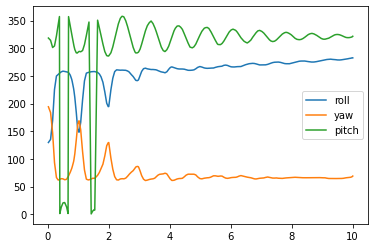

In [6]:
plot_data(gyros_data)

Durch Loesen der Bewegungsgleichungen des Fadenpendels ergibt sich fuer die Kreisfrequenz $\omega_0 = \sqrt{\frac{g}{l}}$. Mit $T_0=\frac{2\pi}{\omega_0}$ also $T_0 = 2\pi \sqrt{\frac{l}{g}}$

In [7]:
t,y = np.array(gyros_data['time']),np.array(gyros_data['pitch'])


In [12]:
import scipy.optimize

def sinfunc(t, A, w, p, c, d=0):  return A * np.sin(w*t + p)*np.exp(-t*d) + c

def fit_sin(t,y, d_guess=0.):
    guess = np.array([
        np.std(y) * np.sqrt(2),   # guess amplitude
        1.*2*np.pi,   # guess ang frequency better guess might be f from FFT (see here: https://stackoverflow.com/questions/16716302/how-do-i-fit-a-sine-curve-to-my-data-with-pylab-and-numpy)
        0.,    # guess phase
        np.mean(y),  # guess offset
        d_guess,  # guess damping constant
    ])

    popt, pcov = scipy.optimize.curve_fit(sinfunc, t, y, p0=guess)
    A, w, p, c, d = popt
    #print(popt)
    #return {'fitfunc':lambda t: A*np.sin(w*t+p)*np.exp(-t*d)+c,'popt':popt,'pcov':pcov}
    return {'fitfunc':lambda t: sinfunc(t,A,w,p,c,d),'popt':popt,'pcov':pcov}

length of pendulum if g=9.81m/s^2 -> l=0.1974+-0.0006 m
g if length of pendulum l=20cm -> g=9.9401+-0.0278 m/s^2


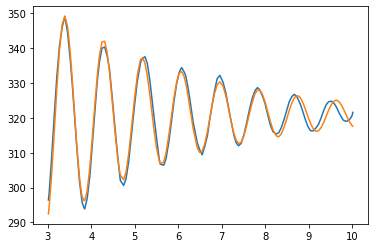

In [13]:
f,ax = plt.subplots()
start_time = 3
start_index = np.argmax(t>start_time)

t_ = t[start_index:]
y_ = y[start_index:]

ax.plot(t_,y_,label='data')

fit = fit_sin(t_,y_,d_guess=0.5)
fitfunc = np.vectorize(fit['fitfunc'])

ax.plot(t_,fitfunc(t_),label='fit')
#print(fit)
w = fit['popt'][1]
werr = np.sqrt(fit['pcov'][1,1])
l_ = 0.2
g_ = 9.81

g = w**2*l_
gerr = 2*w*l_*werr

l = g_/w**2
lerr = np.sqrt((-2.*g_/w**3*werr)**2)


print(f'length of pendulum if g=9.81m/s^2 -> l={l:.4f}+-{lerr:.4f} m')
print(f'g if length of pendulum l={int(100*l_)}cm -> g={g:.4f}+-{gerr:.4f} m/s^2')


In [14]:
print('postfit parameters with uncertainties from cov-matrix')
print('\n'.join([f"{fit['popt'][ip]:.2f} +- {e:.2f}" for ip,e in enumerate(np.sqrt(np.diag(fit['pcov'])))]))

postfit parameters with uncertainties from cov-matrix
79.97 +- 3.91
7.05 +- 0.01
-3.51 +- 0.05
320.86 +- 0.15
0.31 +- 0.01
